# Import dependencies

In [1]:
!pip install torchtext --upgrade > /dev/null 2>&1
!python -m spacy download fr > /dev/null 2>&1
!python -m spacy download en > /dev/null 2>&1

In [2]:
import os
import re
import tqdm
import random
import unicodedata
import numpy as np
import matplotlib.pyplot as plt

import spacy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Example, Field, Dataset
from torchtext.data.iterator import BucketIterator
from torchtext.data.metrics import bleu_score

In [3]:
seed = 781
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [ ]:
!nvidia-smi

# Download data

In [4]:
if not os.path.exists('./data'):
    !mkdir ./data

In [5]:
%%time
!wget --no-check-certificate \
    http://www.statmt.org/europarl/v7/fr-en.tgz \
    -O ./data/fr-en.tgz

--2020-03-25 22:47:40--  http://www.statmt.org/europarl/v7/fr-en.tgz
Resolving www.statmt.org (www.statmt.org)... 129.215.197.184
Connecting to www.statmt.org (www.statmt.org)|129.215.197.184|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202718517 (193M) [application/x-gzip]
Saving to: ‘./data/fr-en.tgz’

./data/fr-en.tgz    100%[===================>] 193.33M   131KB/s    in 25m 59s 

2020-03-25 23:13:38 (127 KB/s) - ‘./data/fr-en.tgz’ saved [202718517/202718517]

CPU times: user 25 s, sys: 7.49 s, total: 32.5 s
Wall time: 25min 58s


In [6]:
%%time
!tar -xzvf ./data/fr-en.tgz -C ./data

europarl-v7.fr-en.en
europarl-v7.fr-en.fr
CPU times: user 108 ms, sys: 20 ms, total: 128 ms
Wall time: 5.59 s


# Data processing

In [5]:
def read_file(filepath):
    try:
        with open(filepath, mode='rt', encoding='utf-8') as file:
            content = file.readlines()
        return content
    except:
        raise NotImplementedError(f'File {filepath} doesn\'t exist')

In [6]:
def unicode_to_ascii(s):
    # NFD => Normal Form Decompose
    # Mn => Non Marking Space
    return ''.join(c for c in unicodedata.normalize('NFD', s) \
                    if unicodedata.category(c) != 'Mn')

def normalize_string(s):
    # Transform accented characters into unaccented ones
    s = unicode_to_ascii(s.strip())
    # Remove a sequence of whitespace characters
    s = re.sub(r'\s+', r' ', s)
    return s.strip()

In [7]:
%%time
pairs = [*zip(read_file('./data/europarl-v7.fr-en.fr'),
              read_file('./data/europarl-v7.fr-en.en'))]
pairs = [*map(lambda x: {'fr': x[0], 'en': x[1]}, pairs)]
print(f'Number of examples: {len(pairs):,}')

Number of examples: 2,007,723
CPU times: user 3.22 s, sys: 1.08 s, total: 4.3 s
Wall time: 7.27 s


I do not build models the entire dataset, since is very large. Instead, I sample a subset of 30,000 sentence pairs.

In [8]:
%%time
pairs = np.random.choice(pairs, size=30000, replace=False)
pairs = [*map(lambda pair: {k: normalize_string(v) for k, v in pair.items()},
              pairs)]
print(f'Number of examples after sampling: {len(pairs):,}')
print(f'Example:\n\tFR => {pairs[0]["fr"]}\n\tEN => {pairs[0]["en"]}')

Number of examples after sampling: 30,000
Example:
	FR => Les procedures par le biais desquelles de tels produits entrent et sortent de l'Union europeenne doivent etre ouvertes, transparentes et, par dessus tout, sures.
	EN => The procedures whereby such products come in and out of the European Union have to be open, transparent and, above all, safe.
CPU times: user 4.25 s, sys: 88 ms, total: 4.34 s
Wall time: 4.34 s


Now, I build the train/valid/test sets.

In [9]:
%%time
FR = Field(init_token='<sos>',
           eos_token='<eos>',
           preprocessing=lambda x: x[::-1],
           lower=True,
           tokenize='spacy',
           tokenizer_language='fr',
           include_lengths=True) # For pack_padded_sequence
EN = Field(init_token='<sos>',
           eos_token='<eos>',
           lower=True,
           tokenize='spacy',
           tokenizer_language='en')

examples = [Example.fromdict(data=pair, fields={'fr': ('src', FR),
                                                'en': ('dest', EN)})
            for pair in tqdm.tqdm(pairs)]
data = Dataset(examples, fields={'src': FR, 'dest': EN})

100%|██████████| 30000/30000 [00:58<00:00, 513.45it/s]

CPU times: user 1min 3s, sys: 488 ms, total: 1min 3s
Wall time: 1min 4s


In [10]:
train_data, valid_data, test_data = data.split(split_ratio=[0.9, 0.05, 0.05])
print(f'train size: {len(train_data.examples)}')
print(f'valid size: {len(valid_data.examples)}')
print(f'test size: {len(test_data.examples)}')
print(vars(train_data.examples[0]))

train size: 27000
valid size: 1500
test size: 1500
{'src': ['.', 'europeenne', 'communaute', 'la', 'de', 'niveau', 'au', 'micro-gestion', 'une', 'a', 'proceder', 'de', 'tentation', 'la', 'a', 'resister', 'de', 'que', 'ainsi', ',', 'terrain', 'de', 'acteurs', 'les', 'par', 'fournies', 'etre', 'peuvent', 'qui', 'competences', 'des', 'et', 'connaissances', 'des', 'ampleur', "l'", 'reconnaitre', 'de', 'important', 'est', 'il', 'et', ',', 'propre', 'specificite', 'sa', 'possede', 'europeennes', 'mers', 'des', 'chacune'], 'dest': ['each', 'of', 'the', 'seas', 'in', 'europe', 'has', 'its', 'own', 'specificity', ',', 'and', 'it', 'is', 'important', 'to', 'recognise', 'the', 'level', 'of', 'knowledge', 'and', 'expertise', 'that', 'can', 'be', 'provided', 'by', 'the', 'stakeholders', 'on', 'the', 'ground', 'and', 'to', 'resist', 'the', 'temptation', 'to', 'micro', '-', 'manage', 'on', 'an', 'eu', 'level', '.']}


Since the model understands only number, we need to transform text sequences into sequence of numbers where each numbers represents an unique word. To do this, we build a vocabulary for each language that map words to indexes and vice versa. the vocabulary id built from train set only in order to prevent data leakage. We also add some special tokens:
- `<sos>`: for start of sentence.
- `<unk>`: for unknown or less frequent words.
- `<eos>`: for end of sentence. 
- `<pad>`: for padding (make all sentences in a batch the same size). 

In [11]:
%%time
FR.build_vocab(train_data,
               min_freq=2,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])
EN.build_vocab(train_data,
               min_freq=2,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])

print(f'Length of FR vocabulary: {len(FR.vocab)}')
print(f'Length of EN vocabulary: {len(EN.vocab)}')

Length of FR vocabulary: 14508
Length of EN vocabulary: 11499
CPU times: user 488 ms, sys: 0 ns, total: 488 ms
Wall time: 487 ms


# Modeling

We used a neural and probabilistic framework to generate english translations of french sentences. The goal is to maximizing the likelihood of a generated english translate given a french sentence.

## Encoder

The part of model map th source sequence to hidden vector

In [13]:
class Encoder(nn.Module):

    def __init__(self, embed_size, vocab_size, hidden_size,
                 n_layers=1, dropout=0, bidirectional=True):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embed_size, hidden_size,
                            num_layers=n_layers,
                            dropout=(dropout if n_layers > 1 else 0),
                            bidirectional=bidirectional)
    
    def forward(self, in_, seq_len):
        """
        inputs
            in_: (seq_len, batch_size)
            seq_len: (batch_size)

        outputs
            out: (seq_len, batch_size, num_directions * hidden_size)
            hn: (num_layers * num_directions, batch_size, hidden_size)
            cn: (num_layers * num_directions, batch_size, hidden_size)
        """
        embedded = self.embedding(in_)
        embedded = self.dropout(embedded)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, seq_len)
        out, (hn, cn) = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(out)
        return out, hn, cn

## Decoder

The part of model performs language modeling given the hidden vector outputs by the encoder.

In [14]:
class Decoder(nn.Module):

    def __init__(self, embed_size, vocab_size, hidden_size,
                 n_layers=1, dropout=0):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embed_size, hidden_size,
                            num_layers=n_layers,
                            dropout=(dropout if n_layers > 1 else 0))
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, in_, h0, c0):
        """
        inputs
            in_: (1, batch_size) => seq_len = 1, a word
            h0: (num_layers, batch_size, hidden_size)
            c0: (num_layers, batch_size, hidden_size)

        embed = self.embedding(_in) 
        # embedded: (1, batch_size, embed_size)
        out, hn, cn = self.lstm(embedded)
        # out: (1, batch_size, hidden_size)
        # hn: (num_layers, batch_size, hidden_size)
        # cn: (num_layers, batch_size, hidden_size)
        logit = self.fc(out.squeeze(0))
        # logit: (batch_size, vocab_size)

        outputs: logit, hn, cn
        """
        embedded = self.embedding(in_)
        embedded = self.dropout(embedded)
        out, (hn, cn) = self.lstm(embedded, (h0, c0))
        logit = self.fc(out.squeeze(0))
        return logit, hn, cn

## Sequence to sequence model

This puts encoder and decoder together.

In [15]:
class SeqToSeqNet(nn.Module):

    def __init__(self, encoder, decoder, device=device):
        assert encoder.n_layers == decoder.n_layers, \
        'Encoder and Decoder have to have the same number of reccurent layers'
        assert encoder.hidden_size == decoder.hidden_size, \
        'Encoder and Decoder have to have the same number of reccurent hidden units'

        super(SeqToSeqNet, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def encode(self, in_, seq_len):
        _, hn, cn = self.encoder(in_, seq_len)
        # Sum the two directional encoder hn state
        if self.encoder.bidirectional:
            hn = hn[:self.encoder.n_layers, :, :] + \
                    hn[self.encoder.n_layers:, :, :]
            cn = cn[:self.encoder.n_layers, :, :] + \
                    cn[self.encoder.n_layers:, :, :]
        return hn, cn

    def decode(self, h_state, c_state, target, sos_index, teacher_forcing, ratio):
        target_len, batch_size = target.size()
        out = torch.zeros((target_len, batch_size, self.decoder.vocab_size),
                           device=self.device)
        in_ = target[0, :].unsqueeze(0)
        for t in range(1, target_len):
            logit, h_state, c_state = self.decoder(in_, h_state, c_state)
            out[t] = logit # (batch_size, vocab_size)
            if teacher_forcing and random.random() < ratio:
                in_ = logit.argmax(1).unsqueeze(0) # (1, batch_size)
            else:
                in_ = target[t, :].unsqueeze(0)
        return out

    def forward(self, in_, seq_len, target, sos_index,
                teacher_forcing=True, ratio=.5):
        """
        inputs
            in_: (seq_len, batch_size)
            seq_len: (batch_size)
            target: (seq_len, batch_size)
            sos_index: int
            eos_index: int

        outputs
            out: (seq_len, batch_size, vocab_size)
        """
        hn, cn = self.encode(in_, seq_len)
        out = self.decode(hn, cn, target, sos_index, teacher_forcing, ratio)
        return out

## Training

In [16]:
def init_weights(model: nn.Module):
    for name, param in model.named_parameters():
        nn.init.uniform_(param.data, a=-0.08, b=0.08)

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
def plot_grad_flow(named_parameters):
    grad_mean, layers = [], []
    for name, param in named_parameters:
        if param.requires_grad and 'bias' not in name:
            layers.append(name)
            grad_mean.append(param.grad.abs().mean())
    plt.plot(grad_mean, alpha=0.3, color='b')
    plt.hlines(0, 0, len(grad_mean) + 1, linewidth=1, color='k' )
    plt.xticks(range(0, len(grad_mean), 1), layers, rotation='vertical')
    plt.xlim(xmin=0, xmax=len(grad_mean))
    # plt.ylim(bottom=-0.001, top=0.02) # Zoom on lower gradients
    plt.xlabel('Layers')
    plt.ylabel('Mean of gradients')
    plt.title('Gradient Flow')
    plt.grid(True)

In [18]:
def train_step(model, opt, loss_func, data_it, grad_clip, sos_index,
               epoch_text=''):
    epoch_loss = 0.
    pbar = tqdm.tqdm(enumerate(data_it), total=len(data_it))
    model.train()
    for i, data in pbar:
        opt.zero_grad()
        logits = model(*data.src, data.dest, sos_index)
        # *data.src: unpack in_ and seq_len
        loss = loss_func(logits[1:].view(-1, logits.size(-1)),
                         data.dest[1:].view(-1))
        loss.backward()
        # plot_grad_flow(model.named_parameters())
        if grad_clip:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        opt.step()
        epoch_loss += loss.item()
        pbar.set_description(epoch_text + f'Train Loss: {epoch_loss/(i+1):.3f}')
    # plt.show() # Show the gradient flow
    return epoch_loss / len(data_it)

In [19]:
def valid_step(model, loss_func, data_it, sos_index, epoch_text=''):
    epoch_loss = 0.
    pbar = tqdm.tqdm(enumerate(data_it), total=len(data_it))
    model.eval()
    with torch.no_grad():
        for i, data in pbar:
            logits = model(*data.src, data.dest, sos_index,
                           teacher_forcing=False)
            loss = loss_func(logits[1:].view(-1, logits.size(-1)),
                             data.dest[1:].view(-1))
            epoch_loss += loss.item()
            pbar.set_description(epoch_text + f'Valid Loss: {epoch_loss/(i+1):.3f}')
    return epoch_loss / len(data_it)


In [20]:
def train(model, optimizer, loss_function, train_it, valid_it, n_epochs, sos_index,
          grad_clip=None, save_to='./saved_models', filename='seq2seq-baseline.pt'):
    assert callable(loss_function)
    if not os.path.exists(save_to):
        !mkdir {save_to}

    history = {'loss': [], 'val_loss': []}
    best_loss = float('inf')
    for epoch in range(n_epochs):
        epoch_text = f'Epoch: {epoch + 1:02d} - '
        loss = train_step(model, optimizer, loss_function, train_it, grad_clip,
                          sos_index, epoch_text)
        val_loss = valid_step(model, loss_function, valid_it, sos_index,
                              epoch_text)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict()},
                       f=os.path.join(save_to, filename))

        history['loss'].append(loss)
        history['val_loss'].append(val_loss)

    return history

In [21]:
EMBEDDING_DIM = 300
HIDDEN_SIZE = 512
N_LAYERS = 2
DROPOUT = 0.5
LR = 1e-3
GRAD_CLIP = 1.0
BATCH_SIZE = 128
N_EPOCHS = 30
MAX_LEN = 50

In [22]:
train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data,
                               test_data),
                              batch_size=BATCH_SIZE,
                              sort_key=lambda x: len(x.src),
                              sort_within_batch=True, # For pack_padded_sequence
                              device=device)

In [23]:
encoder = Encoder(embed_size=EMBEDDING_DIM,
                  vocab_size=len(FR.vocab),
                  hidden_size=HIDDEN_SIZE,
                  n_layers=N_LAYERS,
                  dropout=DROPOUT).to(device)
decoder = Decoder(embed_size=EMBEDDING_DIM,
                  vocab_size=len(EN.vocab),
                  hidden_size=HIDDEN_SIZE,
                  n_layers=N_LAYERS,
                  dropout=DROPOUT).to(device)
seq2seq = SeqToSeqNet(encoder=encoder, decoder=decoder).to(device)
seq2seq.apply(init_weights)
optimizer = optim.Adam(seq2seq.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=EN.vocab.stoi[EN.pad_token])
print(f'Number of parameters of the model: {count_parameters(seq2seq):,}')

Number of parameters of the model: 27,103,199


In [24]:
%%time
history = train(seq2seq, optimizer, criterion, train_iterator, valid_iterator,
                sos_index=EN.vocab.stoi[EN.init_token],
                n_epochs=N_EPOCHS, grad_clip=GRAD_CLIP)

Epoch: 30 - Valid Loss: 4.126: 100%|██████████| 12/12 [00:00<00:00, 18.48it/s]

CPU times: user 25min 7s, sys: 2min 49s, total: 27min 57s
Wall time: 28min 31s


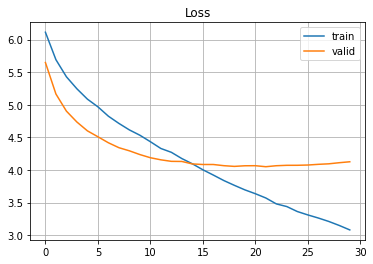

In [27]:
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='valid')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
seq2seq.load_state_dict(torch.load('./saved_models/seq2seq-baseline.pt').get('model'))
test_loss = valid_step(seq2seq, criterion, test_iterator,
                       sos_index=EN.vocab.stoi[EN.init_token],
                       epoch_text='Test loss => ')

Test loss => Valid Loss: 4.082: 100%|██████████| 12/12 [00:00<00:00, 15.54it/s]


# Inference & BLEU score

In [26]:
class Mode:
    """
    Inference methods
    """
    GREEDY = 'GREEDY'
    SAMPLING = 'SAMPLING'
    BEAM_SEARCH = 'BEAM_SEARCH'

In [ ]:
class Inference:
    
    def __init__(self, model, src_field, dest_field, device=device):
        self.model = model
        self.src_field = src_field
        self.dest_field = dest_field
        self.device = device
        
    def greedy_search(self, h_state, c_state, max_len):
        pass
    
    def sampling(self, h_state, c_state, max_len):
        pass
    
    def beam_search(self, h_state, c_state, max_len):
        pass
    
    def inference(self):
        pass

In [ ]:
# %%time
# references = []
# targets_with_sample = []
# targets_without_sample  = []
# seq2seq.eval()
# with torch.no_grad():
#     for i, example in enumerate(test_data.examples):
#         in_ = torch.tensor([FR.vocab.stoi[token]
#                             for token in example.src],
#                         dtype=torch.int64, device=device).unsqueeze(1)
#         if in_.size(0) == 0:
#             print(f'skipped example {i}!')
#             continue
#         seq_len = torch.tensor([in_.size(0)], dtype=torch.int64, device=device)
#         with_ = seq2seq.inference(in_, seq_len, EN.vocab.stoi[EN.init_token],
#                                   EN.vocab.stoi[EN.eos_token], MAX_LEN)
#         without = seq2seq.inference(in_, seq_len,  EN.vocab.stoi[EN.init_token],
#                                     EN.vocab.stoi[EN.eos_token], MAX_LEN, False)
#         targets_with_sample.append([EN.vocab.itos[int(idx)] for idx in with_[0]])
#         targets_without_sample.append([EN.vocab.itos[int(idx)] for idx in without[0]])
#         references.append([example.dest])

In [ ]:
print(f'BLEU score with sampling: {bleu_score(targets_with_sample, references)}')
print(f'BLEU score without sampling: {bleu_score(targets_without_sample, references)}')

In [ ]:
idx = 1
print(' '.join(references[idx][0]))
print('================================')
print(' '.join(targets_with_sample[idx]))
print('================================')
print(' '.join(targets_without_sample[idx]))